In [7]:
import os
import socket

hostname = socket.gethostname()
if hostname == "hctlrds":
    COCO_FOLDER = "/mnt/ssd2/xin/data/coco/"
elif hostname == "Chen-Mac-mini.local":
    COCO_FOLDER = "/Volumes/Storage/Datasets/coco"
else:
    raise NotImplementedError

# distrotion process

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pathlib import Path


from utils import (
    load_camera_params_from_cfg_file,
    ltwh2xyxy,
    xyxy2ltwh,
    annotate_image,
    display_image,
    get_image_path,
    load_target,
    undistort_mesh,
    distort_image,
    get_bounding_rect,
    invert_map,
)

In [3]:
camera_cfg = "2024_8_20_11_38_34_720x960_4149298_2024_08_02_A5PRT9_ip_72_test.cfg"

cam_matrix, dist_vec = load_camera_params_from_cfg_file(camera_cfg)
K = np.array(cam_matrix)
D = np.array(dist_vec)

In [9]:
coco_folder = COCO_FOLDER
split = "val2017"
root = os.path.join(coco_folder, split)
annFile = os.path.join(coco_folder, "annotations", f"instances_{split}.json")

In [10]:
import json

with open(annFile, "r") as f:
    data = json.load(f)
data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [11]:
data["images"][0]

{'license': 4,
 'file_name': '000000397133.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-14 17:02:52',
 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
 'id': 397133}

In [12]:
data["annotations"][0]

{'segmentation': [[510.66,
   423.01,
   511.72,
   420.03,
   510.45,
   416.0,
   510.34,
   413.02,
   510.77,
   410.26,
   510.77,
   407.5,
   510.34,
   405.16,
   511.51,
   402.83,
   511.41,
   400.49,
   510.24,
   398.16,
   509.39,
   397.31,
   504.61,
   399.22,
   502.17,
   399.64,
   500.89,
   401.66,
   500.47,
   402.08,
   499.09,
   401.87,
   495.79,
   401.98,
   490.59,
   401.77,
   488.79,
   401.77,
   485.39,
   398.58,
   483.9,
   397.31,
   481.56,
   396.35,
   478.48,
   395.93,
   476.68,
   396.03,
   475.4,
   396.77,
   473.92,
   398.79,
   473.28,
   399.96,
   473.49,
   401.87,
   474.56,
   403.47,
   473.07,
   405.59,
   473.39,
   407.71,
   476.68,
   409.41,
   479.23,
   409.73,
   481.56,
   410.69,
   480.4,
   411.85,
   481.35,
   414.93,
   479.86,
   418.65,
   477.32,
   420.03,
   476.04,
   422.58,
   479.02,
   422.58,
   480.29,
   423.01,
   483.79,
   419.93,
   486.66,
   416.21,
   490.06,
   415.57,
   492.18,
   416.85,

In [8]:
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


In [9]:
ids = sorted(coco.getImgIds())
id = ids[0]

img_path = get_image_path(coco, id)
targets = load_target(coco, id)

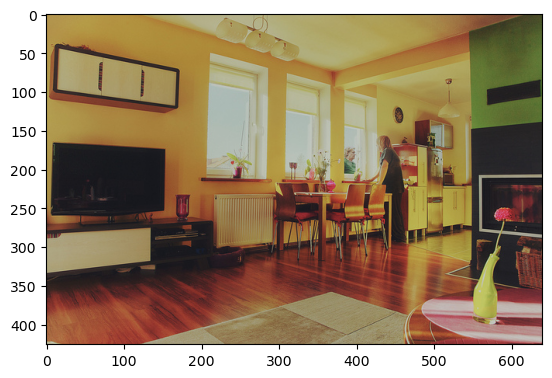

In [10]:
img_path = os.path.join(root, img_path)
img = cv2.imread(img_path)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [11]:
bboxes_xyxy = []
category_ids = []
for target in targets:
    bbox = np.array(target["bbox"])
    bbox = ltwh2xyxy(bbox)
    bboxes_xyxy.append(bbox)
    category_ids.append(target["category_id"])
bboxes_xyxy = np.array(bboxes_xyxy)
category_ids = np.array(category_ids)
confs = None  # gt
category_id_to_name = {k: v["name"] for k, v in coco.cats.items()}

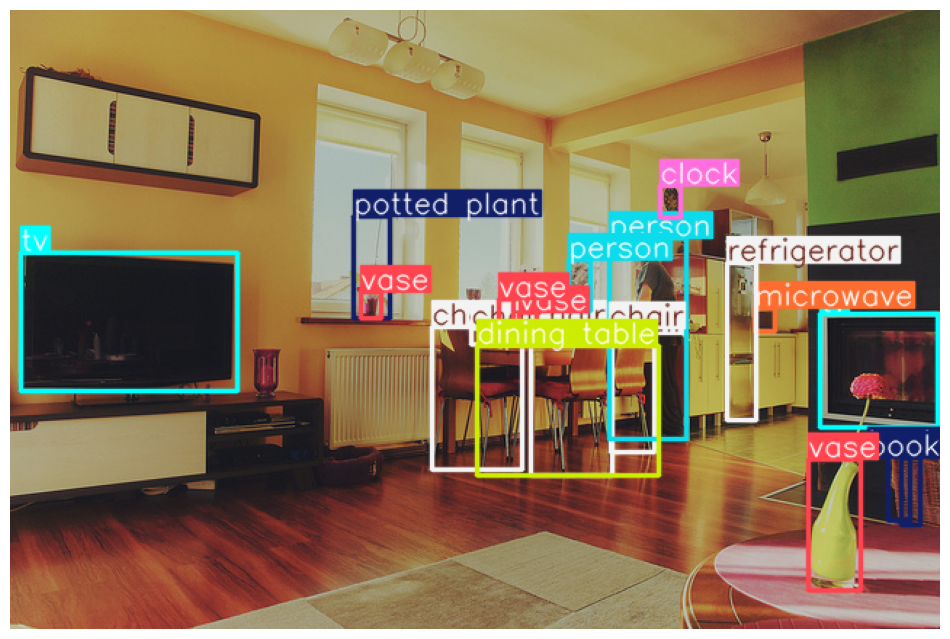

In [12]:
display_image(
    annotate_image(
        img[:, :, ::-1], bboxes_xyxy, category_ids, confs, category_id_to_name
    )
)

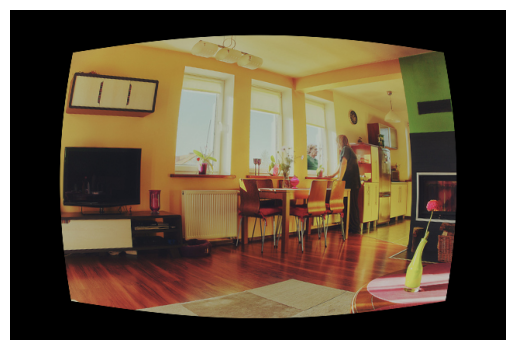

In [15]:
img = cv2.imread(img_path)
u, v = undistort_mesh(img, K, D)

distorted_img = distort_image(img, u, v)

plt.imshow(cv2.cvtColor(distorted_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [16]:
# stack u,v in third dim
uv = np.stack([u, v], axis=-1)
uv_inverse = invert_map(uv)
uv_inverse.shape

(426, 640, 2)

In [17]:
distorted_bboxes_xyxy = []
for bbox in bboxes_xyxy:
    x1, y1, x2, y2 = bbox.astype(int)
    distorted_bboxes_xyxy.append(
        np.concatenate((uv_inverse[y1, x1], uv_inverse[y2, x2]))
    )
distorted_bboxes_xyxy = np.array(distorted_bboxes_xyxy)

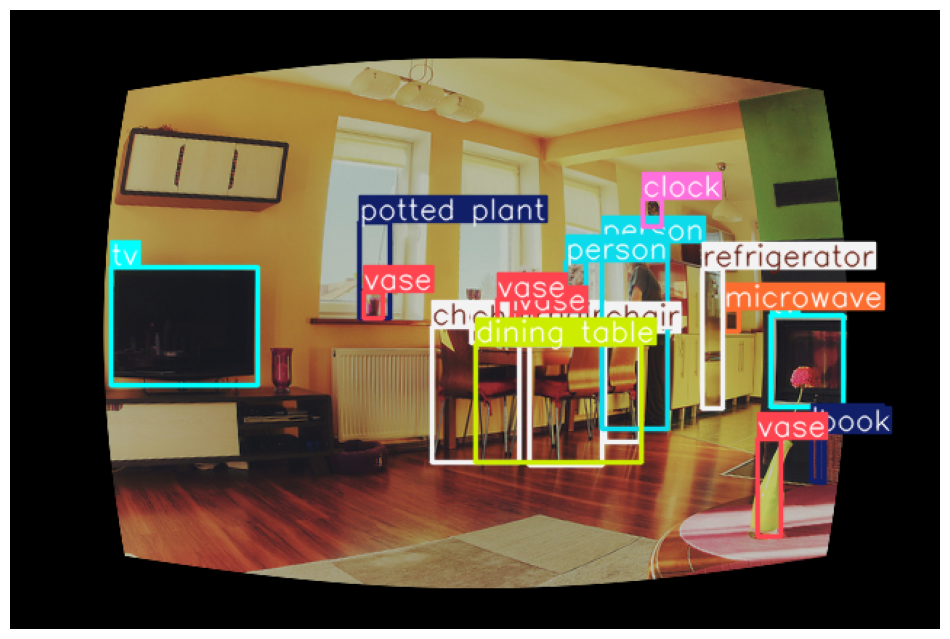

In [18]:
display_image(
    annotate_image(
        distorted_img[:, :, ::-1],
        distorted_bboxes_xyxy,
        category_ids,
        confs,
        category_id_to_name,
    )
)

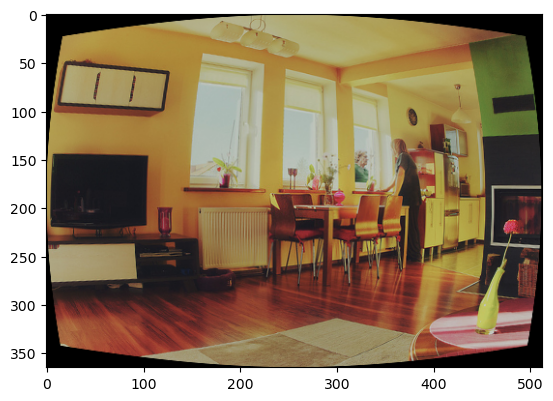

In [19]:
# get rid of the black edges of distorted_img

x, y, w, h = get_bounding_rect(distorted_img)
cropped_distorted_image = distorted_img[y : y + h, x : x + w]
plt.imshow(cv2.cvtColor(cropped_distorted_image, cv2.COLOR_BGR2RGB))

In [20]:
cropped_distorted_bboxes_xyxy = []
for bbox in distorted_bboxes_xyxy:
    bbox = bbox - np.array([x, y, x, y])
    cropped_distorted_bboxes_xyxy.append(bbox)
cropped_distorted_bboxes_xyxy = np.array(cropped_distorted_bboxes_xyxy)

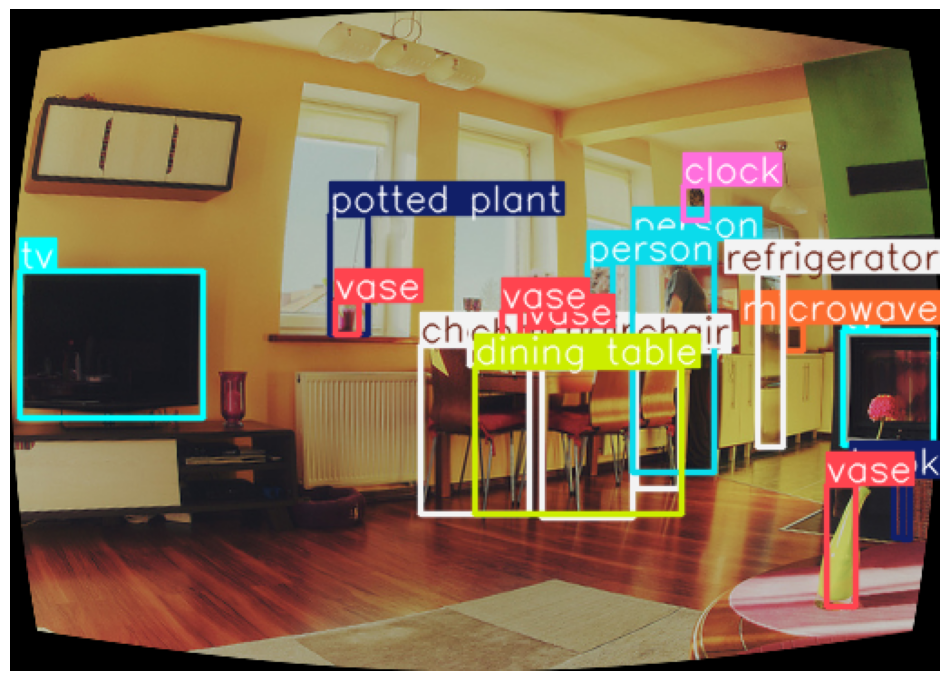

In [21]:
display_image(
    annotate_image(
        cropped_distorted_image[:, :, ::-1],
        cropped_distorted_bboxes_xyxy,
        category_ids,
        confs,
        category_id_to_name,
    )
)

# load from coco_distorted

In [23]:
coco_folder = COCO_FOLDER
split = "val2017"  # TODO

coco_distorted_folder = coco_folder.replace("/coco/", "/coco_distorted/")
root_coco_distorted = os.path.join(coco_distorted_folder, split)
annFile_coco_distorted = os.path.join(
    coco_distorted_folder, "annotations", f"instances_{split}.json"
)

coco = COCO(annFile_coco_distorted)

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [30]:
img_path

'000000000139.jpg'

In [31]:
ids = sorted(coco.getImgIds())
id = ids[0]

img_path = os.path.join(root_coco_distorted, get_image_path(coco, id))
img = cv2.imread(img_path)

In [32]:
targets = load_target(coco, id)

bboxes_xyxy = []
category_ids = []
for target in targets:
    bbox = np.array(target["bbox"])
    bbox = ltwh2xyxy(bbox)
    bboxes_xyxy.append(bbox)
    category_ids.append(target["category_id"])
bboxes_xyxy = np.array(bboxes_xyxy)
category_ids = np.array(category_ids)
confs = None  # gt
category_id_to_name = {k: v["name"] for k, v in coco.cats.items()}

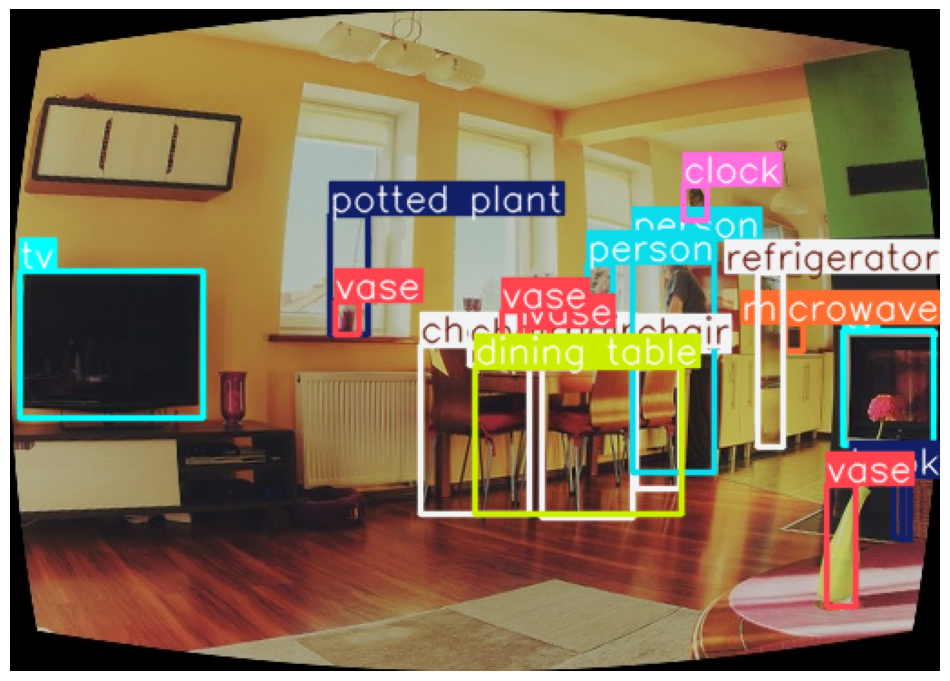

In [33]:
display_image(
    annotate_image(
        img[:, :, ::-1], bboxes_xyxy, category_ids, confs, category_id_to_name
    )
)